<a href="https://colab.research.google.com/github/storimaging/storimaging.github.io/blob/main/ImageGeneration/Texture_synthesis_with_GMMOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture synthesis with GMMOT

## Introduction

This practical session implements the texture synthesis algorithm developed in

[Arthur Leclaire, Julie Delon, Agnès Desolneux. Optimal Transport Between GMM for Texture Synthesis. 2022. hal-03613622](https://hal.archives-ouvertes.fr/hal-03613622/document)

**Texture Synthesis:**

Given an input texture image, produce an output texture image that is both visually similar and pixel-wise different from the input texture. The output image should ideally be perceived as another part of the same large piece of homogeneous material from which the input texture originates.

**Authors:**
* Arthur Leclaire
* Lucía Bouza



## Underlying principle

First, the Texto-GMM model is defined at one single scale, as a transformation of a stationary Gaussian random field. Next, it is extended to a multi-scale framework by using successive exemplar-based upsampling steps.

Let $u : \Omega \to \mathbb{R}^d$ be the exemplar texture defined on a rectangular domain $\Omega \subset \mathbb{Z}^2$.

Let also $\omega = \{0, \ldots, w-1\}^2$ be the patch domain with patch size $w$, and $u_{|a+\omega} \in \mathbb{R}^{\omega}$ be the patch at position $a$.

### The monoscale model

The monoscale model can be decomposed as a coarse Gaussian synthesis followed by a patch-based enhancement.

The Gaussian model ADSN used for coarse synthesis is defined by

\begin{equation}
 \forall\, a \in \mathbb{Z}^2, \quad U(a) = \bar{u} + \frac{1}{\sqrt{|\Omega|}} \sum_{b \in \Omega} (u(b)-\bar{u}) W(a-b)
\end{equation}

where $\bar{u} = \frac{1}{|\Omega|} \sum_{a\in\Omega} u(a)$ and where $W$ is a Gaussian white noise on $\mathbb{Z}^2$ (i.e. the $W(x)$ are i.i.d. $\mathcal{N}(0,1)$).
The field $U$ is a stationary Gaussian random field with mean $\bar{u}$ and whose covariance equals the empirical covariance of $u$.

Then, a patch transformation $T : \mathbb{R}^\omega \to \mathbb{R}^\omega$ is applied to get a new field $V$ given by
\begin{equation}
\forall a \in \mathbb{Z}^2, \quad
V(a) = \frac{1}{|\omega|} \sum_{h \in \omega} T(U_{|a-h+\omega})(h).
\end{equation}

The patch transformation $T$ is adjusted so that it sends the distribution $\mu$ of the Gaussian patch $U_{|\omega}$ to the patch distribution of $u$. This allows to reimpose local features observed in $u$ in a statistically coherent way.
We here exploit GMM-OT to get a relevant patch transformation.
Indeed, we can first use the EM algorithm to fit a GMM distribution $\nu$ to the patches of $u$, and then solve the GMM-OT between the Gaussian measure $\mu$ and the GMM $\nu$.
Once the GMM-OT problem solved, we get the patch transformation $T$  from the optimal plan $\gamma^*$ given by

\begin{equation}
T(x) = \mathbb{E}_{(X,Y)\sim\gamma^*} (Y | X=x).
\end{equation}

The closed-form formula for $T$ is given by
\begin{equation}
T(x) = \frac{\sum_{k,l}
w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x) T_{k,l}(x)}{\sum_{k} \pi^k_{0} g_{m_0^k,\Sigma_0^k}(x)},
\end{equation}

where $w^*$ is the optimal solution of the discrete problem, $T_{k,l}$ are the optimal affine maps between Gaussians $\mu_0^k$ and $\mu_1^l$, and $ g_{m,\Sigma}$ is the density of $\mathcal{N}(m,\Sigma)$.

## Importing packages

Below is a list of packages needed and a brief explanation of its use in this notebook:

- `numpy` (library used for working with arrays)
- `matplotlib` (to load and display images)
-  `scipy.linalg` (library used for linear algebra functions)
- `scipy.stats` (library used for probability density functions)
-  `ot` (Optimal Transport library https://github.com/rflamary/POT)
- `os` (to execute scripts with parameters into Python code)

In order to use the Optimal Transport library we must first install it using PIP.

In [16]:
!pip install POT

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import ot                 # Optimal Transport library https://github.com/rflamary/POT
import sklearn.mixture    # for EM
import os
from skimage.transform import resize
import time

This notebook uses auxiliar functions to get patches from images, compute a Gaussian synthesis for initialization, compute optimal transport plans and maps between Gaussian mixture models, etc.. In the next cell we import this functions.

In [18]:
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/AuxiliarFunctions/Texture_synthesis_with_GMMOT.py")
from Texture_synthesis_with_GMMOT import *

## Loading images

In the next cell we upload texture images. We can choose the texture to work with from the images uploaded, by changing the parameter of the loadImage function.

In [19]:
# Small textures: "ground1013_small.png", "Fabric-02.png", "Fabric-13.png", "Rdesign5.png", "red_peppers.png"
# Large textures (takes longer): "raad2.png","raad7.png", "raad8.png", "raad10.png"
texture_imgnames = ["ground1013_small.png", "Fabric-02.png", "Fabric-13.png", "Rdesign5.png", "red_peppers.png","raad2.png","raad7.png", "raad8.png", "raad10.png"]

# Download images
for fname in texture_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/Textures/"+fname)


# Helper funtion to load images
def loadImage(input_image_name):
    u = plt.imread(input_image_name)

    #removing alpha chanel
    if u.shape[2]==4:
      u = u[:,:,:3]

    if input_image_name[-3:]=="jpg"  or input_image_name[-4:]=="jpeg" or input_image_name[-3:]=="bmp":
        u = u/255

    return u

# load the image to work in next sections.
u = loadImage("ground1013_small.png")
m,n,nc=u.shape

## ADSN initialization

We will use the ADSN model to initialize the synthesis.

Let $h\in\mathbb{R}^{M\times N\times 3}$ be a an image, $m = (m_r, m_g, m_b)$ be the mean color of $h$ and $X$ be a Gaussian white noise image.
The random image
$$
Y = m + \frac{1}{\sqrt{MN}}
\begin{pmatrix}
\left( h_r - m_r \right) \ast X\\
\left( h_g - m_g \right) \ast X\\
\left( h_b - m_b \right) \ast X
\end{pmatrix}
$$
is the ADSN associated with $h$.

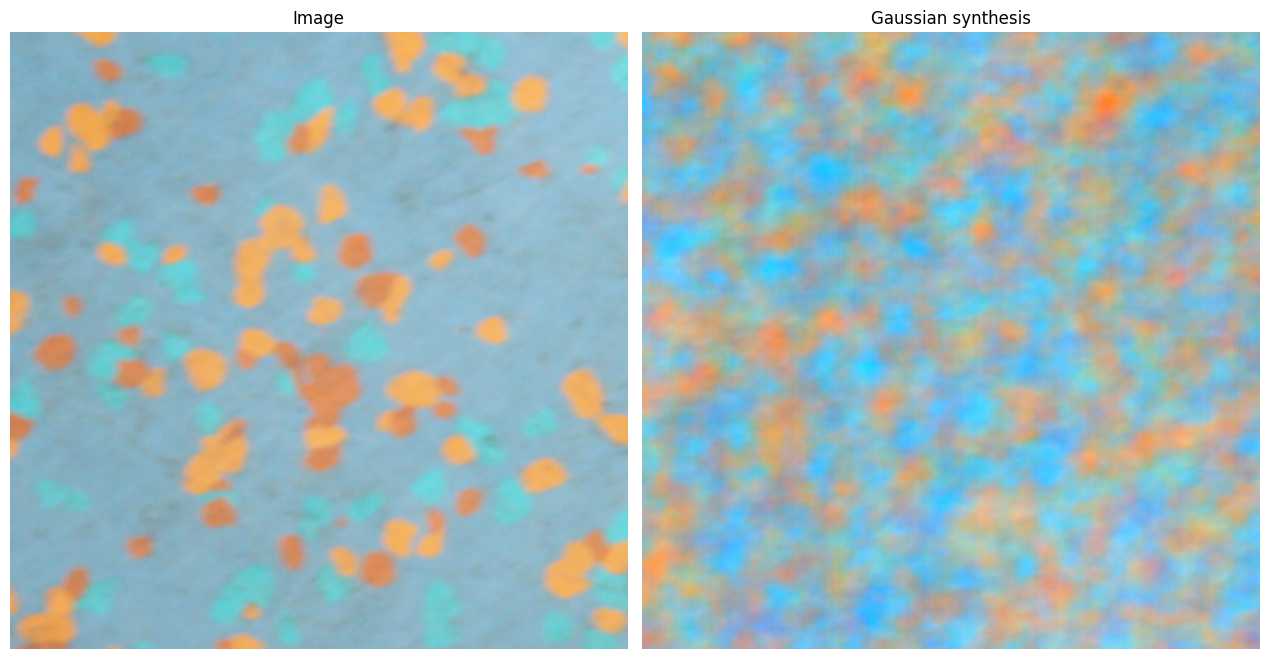

In [20]:
np.random.seed(0)   # fix random seed

v = gaussian_synthesis(u)

#  Scale factor
dpi = 20

# Plot both images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(m/float(dpi),n/float(dpi)))
axes[0].imshow(u)
axes[0].axis('off')
axes[0].set_title('Image')
axes[1].imshow(np.clip(v,0,1))
axes[1].axis('off')
axes[1].set_title('Gaussian synthesis')
fig.tight_layout()

## Compute patches

In the next cell we extract patches of the original image and the Gaussian synthesis.

In [21]:
# Construct patch operators and extract patches
w = 5
s = 1
npatches = 1000    # npatches could be increased to improve visual quality (but requires more time)

X, _ = patches(v, w, s)
Y, _ = patches(u, w, s, npatches = npatches)

Estimate target measure with 1000 patches


## Estimate GMM models

In this section we estimate patch GMM for the original image and the synthesis.

In [22]:
ngmm = 4 # same for input and output (unless 1 Gaussian for input)

# Estimate GMM model with K0 components for v (Gaussian Synthesis)
gmmX = sklearn.mixture.GaussianMixture(n_components= ngmm, covariance_type='full').fit(X)
# Estimate GMM model with K1 components for u (target)
gmmY = sklearn.mixture.GaussianMixture(n_components= ngmm, covariance_type='full').fit(Y)

## Optimal transport

We define a function  `GMM_Optimal_Transport_NN` which
- computes the optimal transport plan between the components of the mixture models with the function `DW`,

- computes the optimal transport map between each pair of components of the two mixture models, using the function `GaussianMap`,

- transports all patches with the GMMOT map,

- reprojects the transported patches on original patches.

In [23]:
# GMM Optimal transport
Tmeanx, Tmeanxnn, _ = GMM_Optimal_Transport_NN(gmmX, gmmY, X, Y)

Display results:

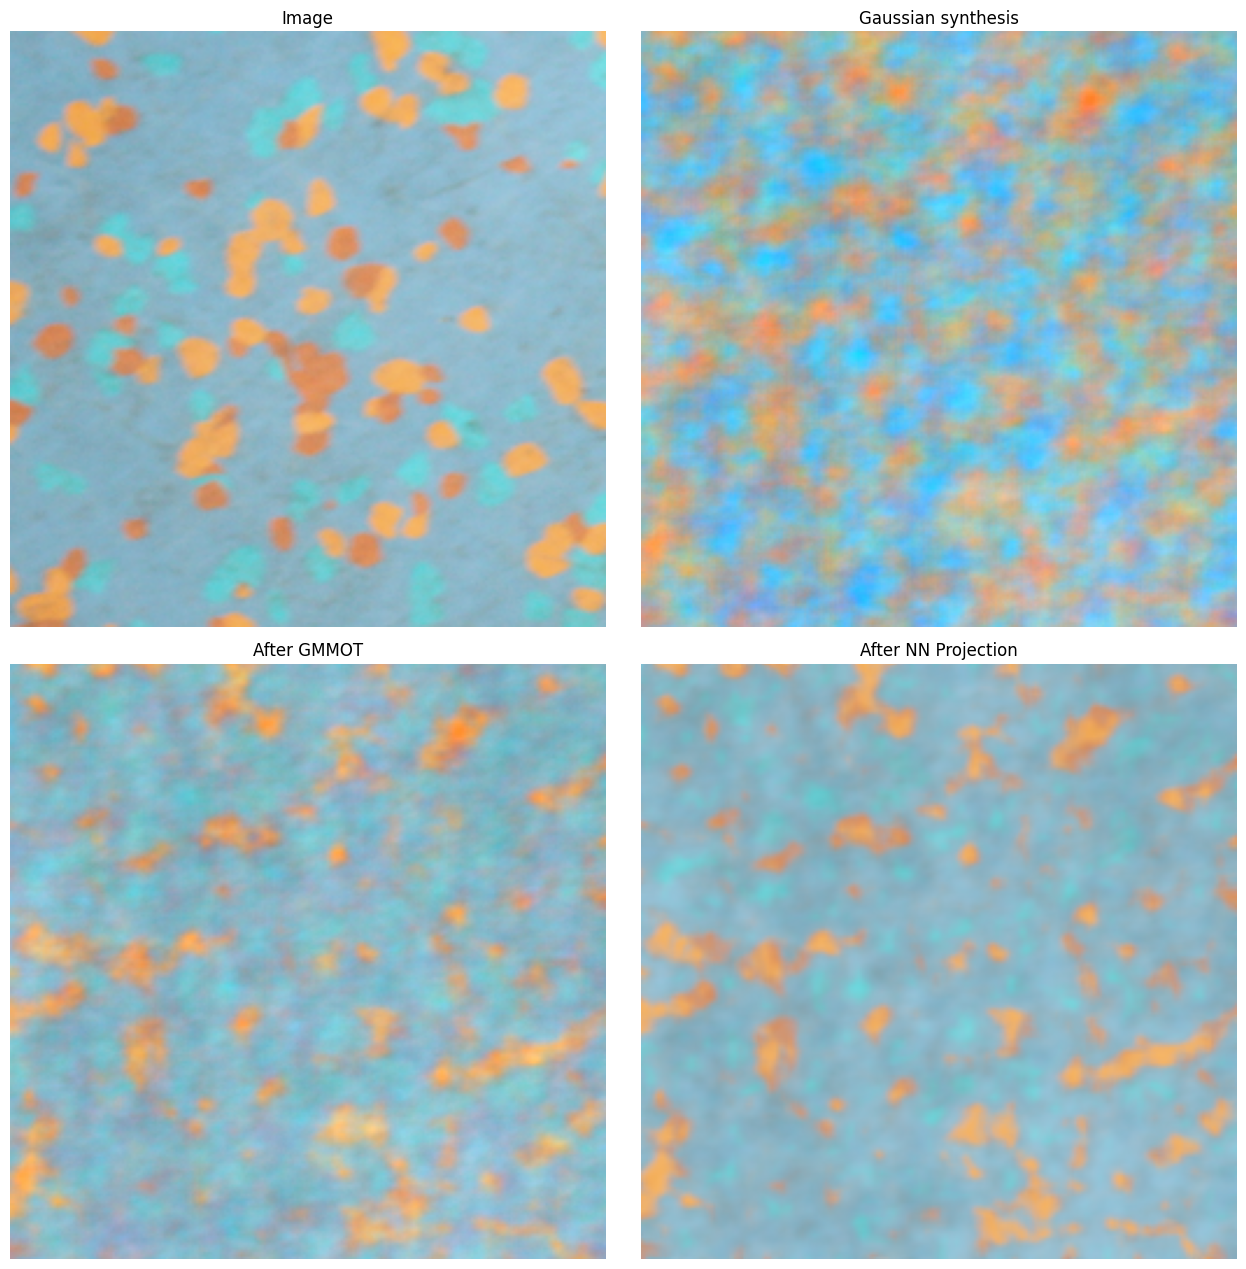

In [24]:
# Plot images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(m/float(dpi),n/float(dpi)))
axes[0][0].imshow(u)
axes[0][0].axis('off')
axes[0][0].set_title('Image')
axes[0][1].imshow(np.clip(v,0,1))
axes[0][1].axis('off')
axes[0][1].set_title('Gaussian synthesis')
axes[1][0].imshow(np.clip(patch2im(Tmeanx,w,m,n,s),0,1))   # PATCHES
axes[1][0].axis('off')
axes[1][0].set_title('After GMMOT')
axes[1][1].imshow(np.clip(patch2im(Tmeanxnn,w,m,n,s),0,1))      # PATCHES
axes[1][1].axis('off')
axes[1][1].set_title('After NN Projection')
fig.tight_layout()
plt.show()

## Multiscale Model

We will now see how the texture model can be extended in a multiscale fashion.

For $0 \leqslant s \leqslant S-1$, we consider a subsampled version $u_s$ of $u$ at resolution $2^{-s}$
defined on a subdomain ${\Omega_s \subset 2^s \mathbb{Z}^2}$.
We will also denote by $\nu_s$ a GMM distribution that is fitted by EM to the empirical distribution of the $w\times w$ patches of $u_s$.

The multiscale Texto-GMM model is defined in a coarse-to-fine manner.
At the coarsest scale $s = S-1$, $U_{S-1}$ is initialized as the Gaussian field estimated from $u_{S-1}$.
Suppose now that $U_s$ at scale $s \in \{1, \ldots, S-1\}$ is given.
Then, a GMM model $\mu_s$ is fitted to the patches of $U_s$, and an optimal transport plan $\gamma_s^*$ for $MW_2(\mu_s,\nu_s)$ is computed. Then, $U_s$ is transformed using the map $T_s$ related to $\gamma_s^*$.

However, for the need of the upcoming upsampling step, we need to compose with a $L^2$ nearest-neighbor projection on the exemplar patches at scale $s$.

Thus, denoting by $C_s(a)$ the coordinate of the nearest neighbor of $T_s({U_s}_{|a + 2^s\omega})$ in $u_s$, we set
\begin{equation}
  V_s(a) = \frac{1}{|\omega|} \sum_{b \in 2^s\omega} u_s\big(C_s(a-b)+b\big) ,\ a \in 2^s \mathbb{Z}^2.
\end{equation}
This allows to upsample by taking twice larger patches at the same positions, thus initializing $U_{s-1}$ for the next finer scale: for all $a \in 2^s\mathbb{Z}^2$ and for all $k \in \{0,\ldots, 2^{s-1}\}^2$, we set
\begin{equation}
U_{s-1}(a+k) = \frac{1}{|\omega|}\sum_{b \in 2^s\omega} u_{s-1}\big(C_s(a-b)+b+k\big).
\end{equation}
At the end, we obtain the sample texture image $V_0$.

Let us finally mention that, once the model estimation has been done (i.e. when all GMM models are estimated and all transport plans $\gamma_s^*$ have been computed using one synthesis), then the model can be synthesized offline to produce (possibly-larger) images on-demand.

Iteration scale:  3
Estimate target measure with 784 patches


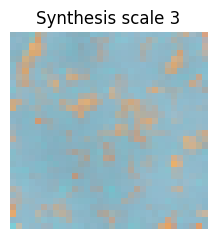

Iteration scale:  2
Estimate target measure with 1000 patches


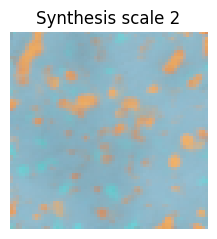

Iteration scale:  1
Estimate target measure with 1000 patches


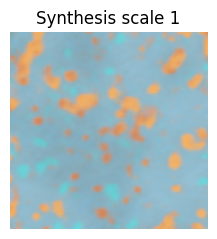

Iteration scale:  0
Estimate target measure with 1000 patches


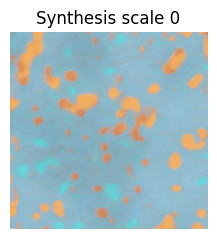

Elapsed time =  38.31442856788635


In [25]:
np.random.seed(0)   # fix random seed

# Parameters
nscales = 4
ngmm = 4
imgs = []

# Coarse-to-fine Synthesis

t0 = time.time()
for scale in range(nscales-1, -1, -1):
    print("Iteration scale: ", scale)

    # Original image at current scale
    rf = 2**scale
    msc = int(np.ceil(m/rf))
    nsc = int(np.ceil(n/rf))
    im0sc = resize(u, (msc, nsc), order=3, clip = False, anti_aliasing=False, mode='symmetric');
    if scale>0:  # if necessary, original image at the next scale
       im0sc2 = resize(u, (2*msc, 2*nsc), order=3, clip = False, anti_aliasing=False, mode='symmetric');

    # Gaussian synthesis for the first iteration
    if scale == nscales-1:
        synthbt = gaussian_synthesis(im0sc)

    # Construct patch operators and extract patches
    P0, selec = patches(im0sc,w,s,npatches = npatches)
    Pbt, _ = patches(synthbt,w,s)
    if scale>0: P02, _ = patches(im0sc2,2*w,2*s,selec = selec)

    # Estimate GMM model with K0 components for v (current synthesis)
    gmmX = sklearn.mixture.GaussianMixture(n_components= ngmm, covariance_type='full').fit(Pbt)

    # Estimate GMM model with K1 components for u (exemplar texture)
    gmmY = sklearn.mixture.GaussianMixture(n_components= ngmm, covariance_type='full').fit(P0)

    # GMM Optimal transport
    Tmeanx, Tmeanxnn, ind = GMM_Optimal_Transport_NN(gmmX, gmmY, Pbt, P0)

    # Aggregate patches
    synth = patch2im(Tmeanxnn,w,msc,nsc,s)            # PATCHES
    if scale > 0:
        # Upsample current synthesis
        Psynth2 = P02[ind,:]
        # Set initial synthesis for next iteration
        synthbt = patch2im(Psynth2,2*w,2*msc,2*nsc,2*s)     # PATCHES

    plt.figure(figsize=(m/float(100), n/float(100)))
    plt.imshow(synth)
    plt.title('Synthesis scale %i' %scale)
    plt.axis('off')
    plt.show()

    # Add Synth to list
    imgs.append(synth)

print('Elapsed time = ',time.time()-t0)

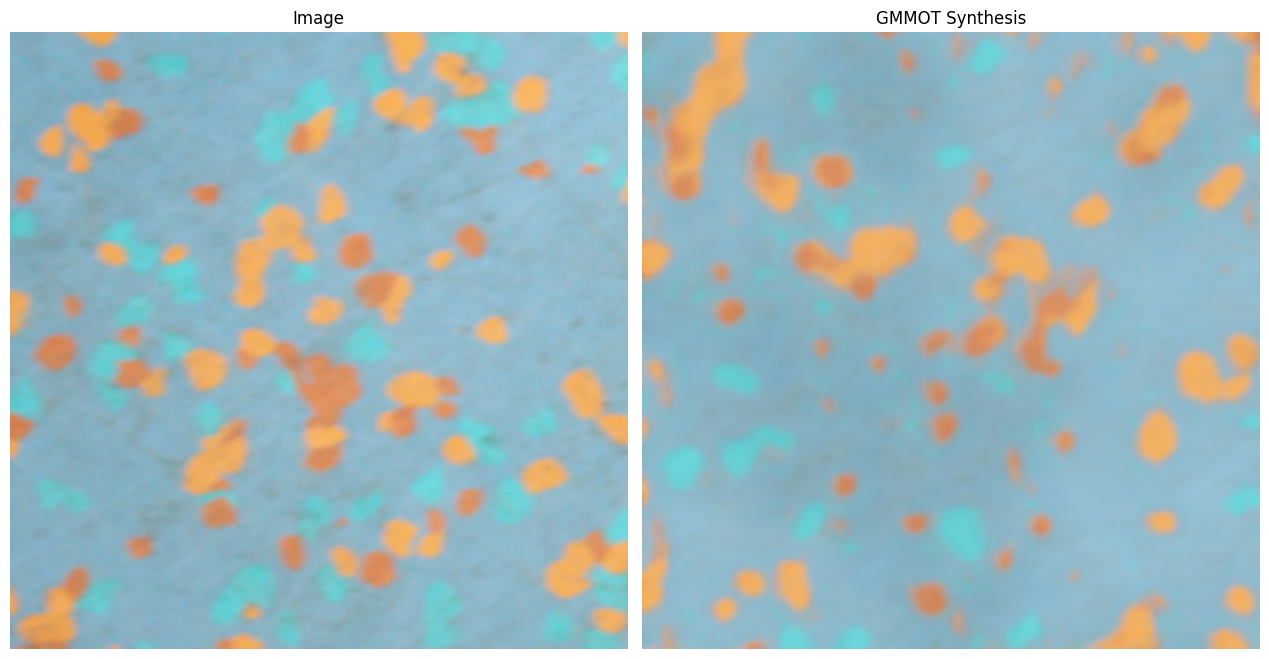

In [26]:
# Plot images
dpi=20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(m/float(dpi),n/float(dpi)))
axes[0].imshow(u)
axes[0].axis('off')
axes[0].set_title('Image')
axes[1].imshow(np.clip(synth,0,1))
axes[1].axis('off')
axes[1].set_title('GMMOT Synthesis')
fig.tight_layout()
plt.show()

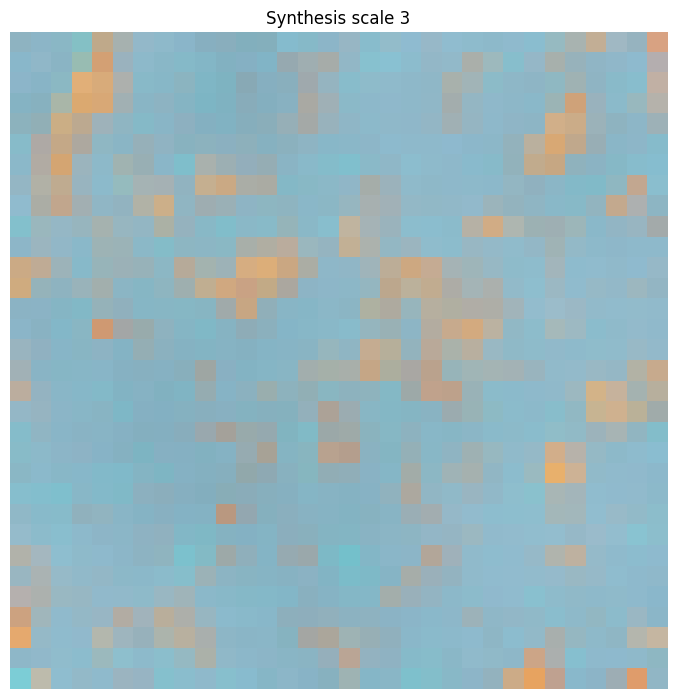

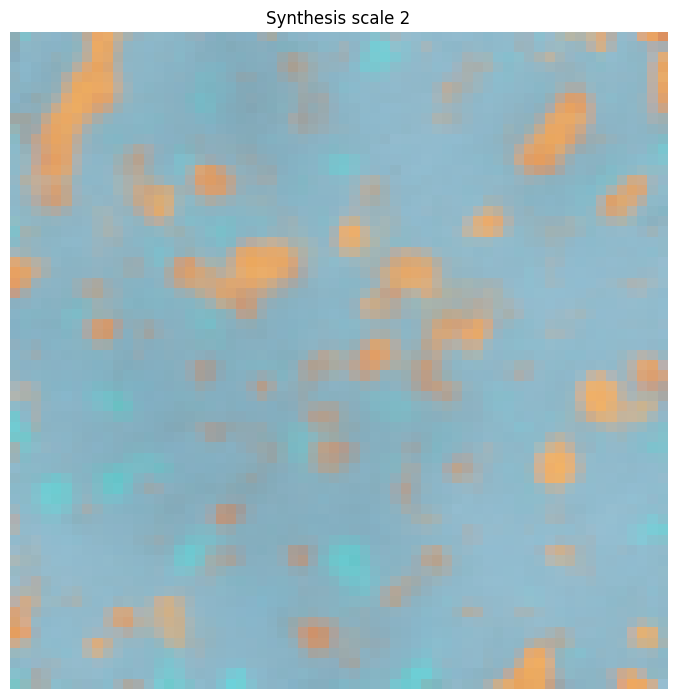

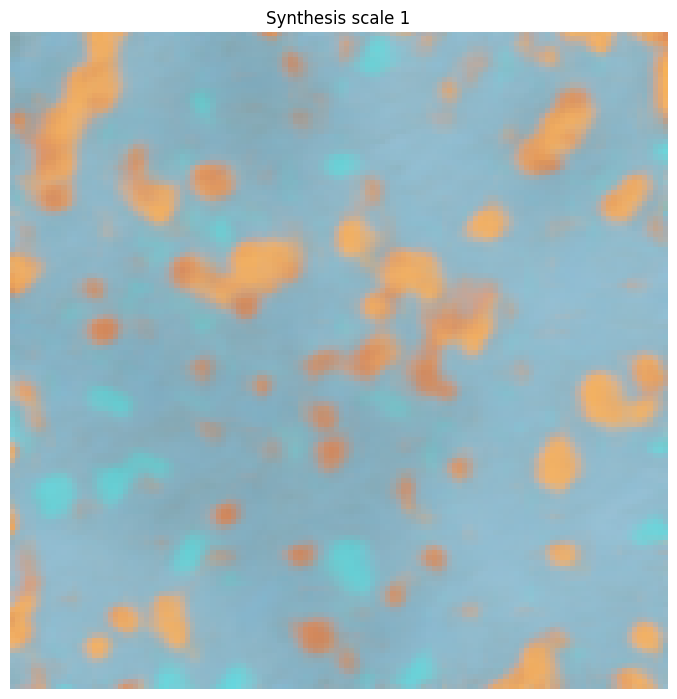

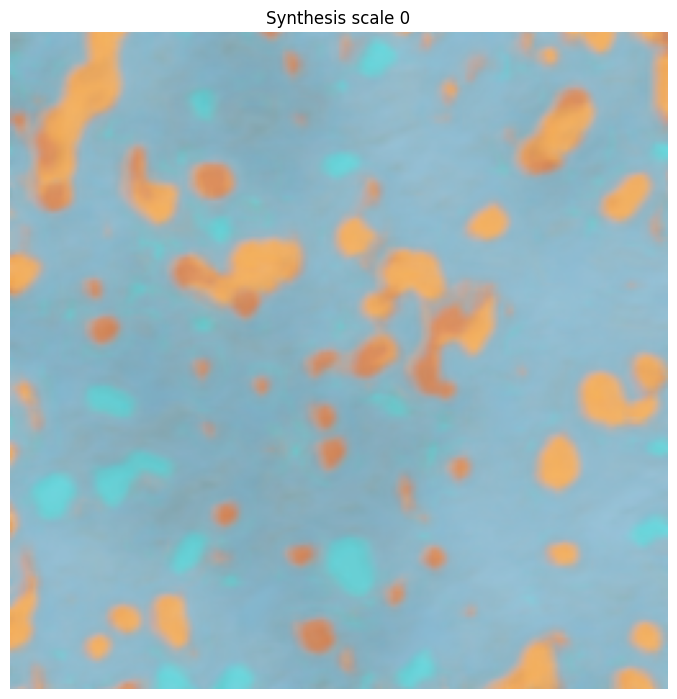

In [27]:
def compare_images(imgs):
    dpi = 30
    for i, img in enumerate(imgs):
        plt.figure(figsize=(m/float(dpi), n/float(dpi)))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Synthesis scale %i' %(nscales-1-i))

compare_images(imgs)